In [1]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.sw.info

import rtmtools.rrtmg.sw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.sw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)


<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

In [2]:
name_molecule = r'$H_{2}O$'

In [3]:
# Load CRD results
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/SW/examples/mls75_H2O/OUTPUT_CRD.dat'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, signed_fluxes = True)

In [7]:
# Load CLIRAD results
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/SW/examples/mls75_H2O/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, signed_fluxes = True)

In [4]:
# Load AER RRTMG's results
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/SW/examples/mls_71lvls_H2O/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True)

In [94]:
# Plot downward flux

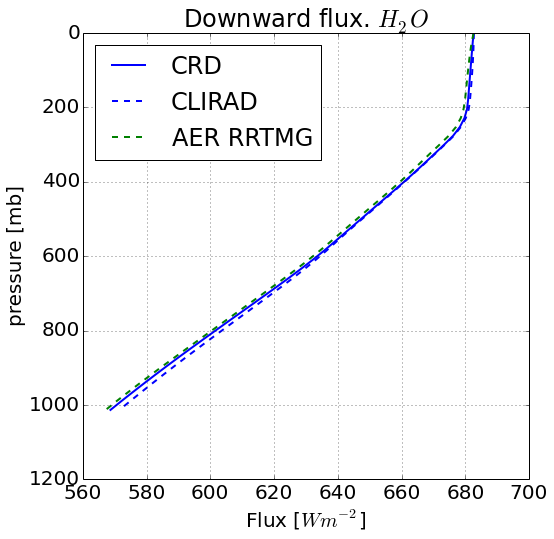

In [95]:
matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111,
                     title = 'Downward flux. $H_2O$',
                     xlabel = 'Flux [$W m^{-2}$]',
                     ylabel = 'pressure [mb]')

lines = ax.plot(fd_crd, Pres_crd,
                fd_clirad / fd_clirad[0] * fd_crd[0], Pres_clirad,
                fd_rrtmg / fd_rrtmg[0] * fd_crd[0], Pres_rrtmg)

ax.set_yscale('linear')
#ax.set_xlim(left = 520., right = 690.)
#ax.set_ylim(bottom = 0., top = 1020.)
#ax.set_xlim(left = 670., right = 685.)
#ax.set_ylim(bottom = 0., top = 100.)

linestyles = ['-', '--', '--']
colours   = ['b', 'b', 'g']

[plt.setp(line, linestyle = style, color= colour, linewidth = 2.)\
 for line, style, colour in zip(lines, linestyles, colours)]

plt.grid(b = True)
plt.legend(['CRD', 'CLIRAD', 'AER RRTMG',], loc = 'best')
plt.gca().invert_yaxis()

#plt.savefig('SW_flux_H2O_no_rayleigh.pdf')

In [96]:
# Plot heating rates

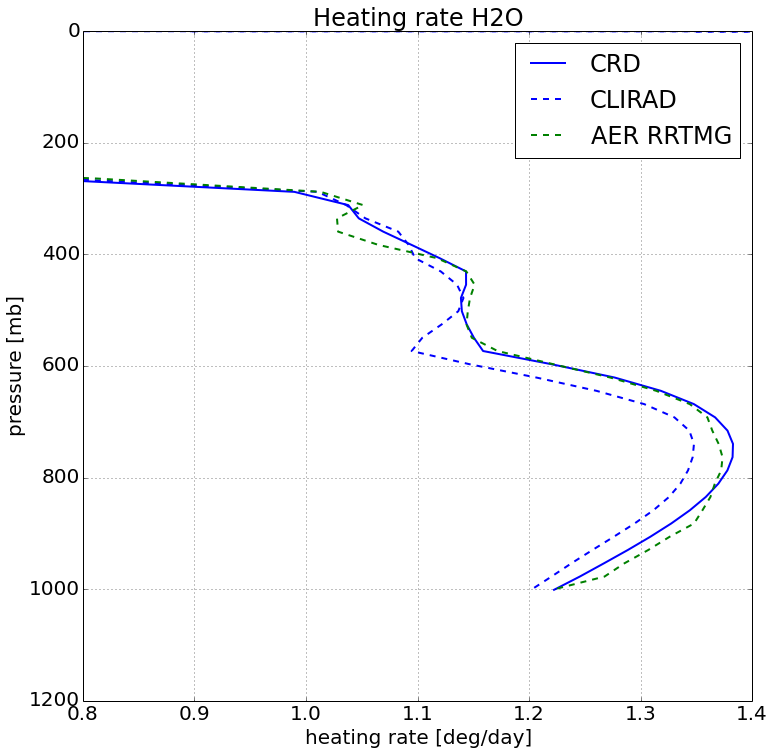

In [20]:
matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111,
                     title = 'Heating rate H2O',
                     xlabel = 'heating rate [deg/day]',
                     ylabel = 'pressure [mb]')

lines = ax.semilogy(hr_crd, pres_crd,
                    hr_clirad, pres_clirad,
                    hr_rrtmg, pres_rrtmg)

ax.xaxis.get_major_formatter().set_powerlimits((0, 1))

#ax.set_yscale('log')
#ax.set_xlim(left = -0.02, right = 1.5)

ax.set_yscale('linear')
ax.set_xlim(left = 0.8, right = 1.4)

linestyles = ['-', '--', '--']
colours    = ['b', 'b', 'g']

[plt.setp(line, linestyle = style, color = colour, linewidth = 2.) \
for line, style, colour in zip(lines, linestyles, colours)]

plt.grid(b = True)
plt.legend(['CRD', 'CLIRAD', 'AER RRTMG'], loc = 'best')
plt.gca().invert_yaxis()

#plt.savefig('hr_mls_H2O_lineary.png')

In [15]:
def plot_total_heating_rates(infos_wavenumber = None, infos_spectralband = None):
    global molecule_name, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names_wavenumber, colours_wavenumber, linestyles_wavenumber, pnls_wavenumber = \
    map(list, zip(*infos_wavenumber))
    
    dfs_wavenumber = [aeranalyse.sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 0, V2 = 3000) \
                      for pnl in pnls_wavenumber]
    
    names_spectralband, colours_spectralband, linestyles_spectralband, pnls_spectralband = \
    map(list, zip(*infos_spectralband))
    
    dfs_spectralband = [cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl, wbands = range(1, 11))\
                       for pnl in pnls_spectralband]

    dfs = dfs_wavenumber + dfs_spectralband
    names = names_wavenumber + names_spectralband
    colours = colours_wavenumber + colours_spectralband
    linestyles = linestyles_wavenumber + linestyles_spectralband    
    
    dfs_atm_levels = [df.loc[atm_levels, :] for df in dfs]
    
    viz.tabulate_difference(dfs = dfs_atm_levels, 
                            names = names,
                            title = 'Total heating rate. {}'.format(name_molecule))    
    
    max_cr = max([df['heating_rate'].max() for df in dfs])
    
    viz.plot_pres_vs_hrcr(dfs = dfs_wavenumber + dfs_spectralband,
                          names = names_wavenumber + names_spectralband,
                          linestyles = linestyles_wavenumber + linestyles_spectralband, 
                          colours = colours_wavenumber + colours_spectralband,
                          title = 'Total heating rate. {}'.format(name_molecule),
                              cooling_rate = False,
                         xlim_linear = xlim_linear,
                          xlim_log = (- .1, 20) if max_cr >= 20 else None)
    
    display.display(plt.gcf()); plt.close()
    


Total heating rate. $H_{2}O$

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   9.621729  9.621729      0.075454
30   299.800000        0   8.949147  8.949147      0.060985
0   1013.000000        0   5.673466  5.673466      0.037163

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70     0.00242        0             0       12.4995    12.4995   12.4995   
30   299.70000        0             0       10.6399    10.6399   10.6399   
0   1013.00000        0             0        4.7503     4.7503    4.7503   

    heating_rate  
70       0.00000  
30       0.08237  
0        0.05769  

CLIRAD
       pressure   flux_up   flux_down    net_flux  heating_rate
70     0.002417 -0.000233  684.071315  684.071082      1.135757
30   299.800000 -0.000088  673.559924  673.559836      0.990692
0   1013.000000  0.000000  571.877265  571.877265      1.200381

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_

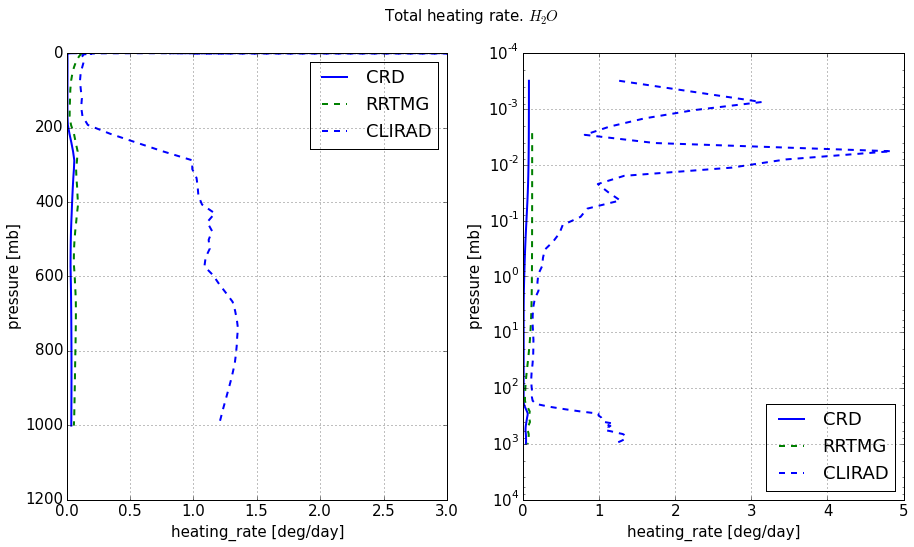

In [18]:
xlim_linear = (0, 3)

plot_total_heating_rates(infos_wavenumber = [('CRD', 'b', '-', pnl_crd),
                                            ('RRTMG', 'g', '--', pnl_rrtmg)],
                        infos_spectralband = [('CLIRAD', 'b', '--', pnl_clirad)])

In [26]:
# By arbitrary bands

def define_spectral_bands():
    return [(1000, 4400),
           (4400, 8200),
           (8200, 14280),
           (14280, 25000),
           (1000, 25000)]


def fluxtableNhrplot_by_bands(bands, *infos_lbl):
    global name_molecule, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
          
    pnls = [aeranalyse.lines2bands(pnl_lbl, wbands = bands)\
            for pnl_lbl in pnls_lbl]
    
    
    for item in bands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in pnls]
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {} ~ {} cm-1'.format(*item))      
        
        dfs = [pnl[item] for pnl in pnls]
        
        max_cr = max([df['heating_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Heating rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = False,
                             xlim_linear = xlim_linear,
                             xlim_log = (- .5, 20) if max_cr >= 20 else None)
    
        display.display(plt.gcf()); plt.close()

Flux tables and heating rates in various spectral bands


---------------------------------------------------------------------------


Wavenumber band: 1000 ~ 4400 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  29.352153  29.352153      0.351053
30   299.800000        0  25.503405  25.503405      0.355012
0   1013.000000        0  10.547747  10.547747      0.100244



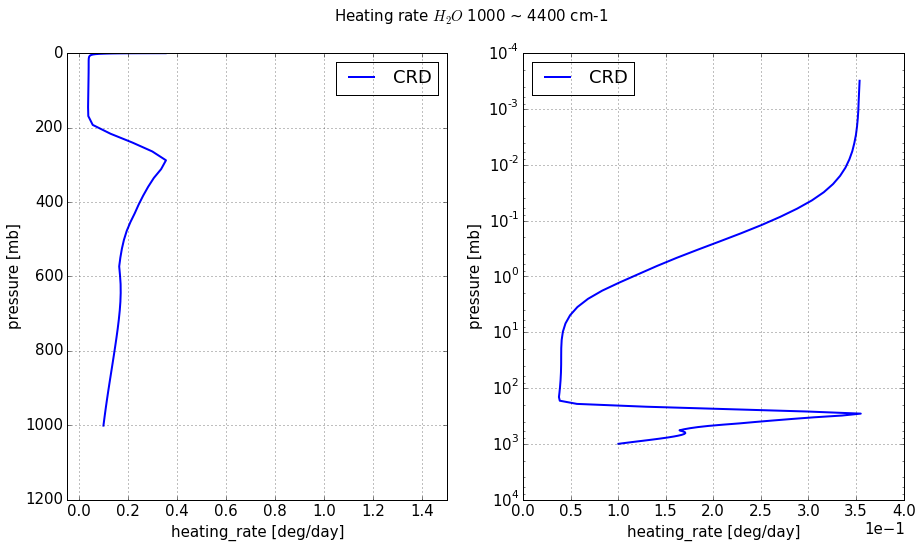

---------------------------------------------------------------------------


Wavenumber band: 4400 ~ 8200 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  113.874482  113.874482      0.104813
30   299.800000        0  109.312006  109.312006      0.514142
0   1013.000000        0   65.972910   65.972910      0.315031



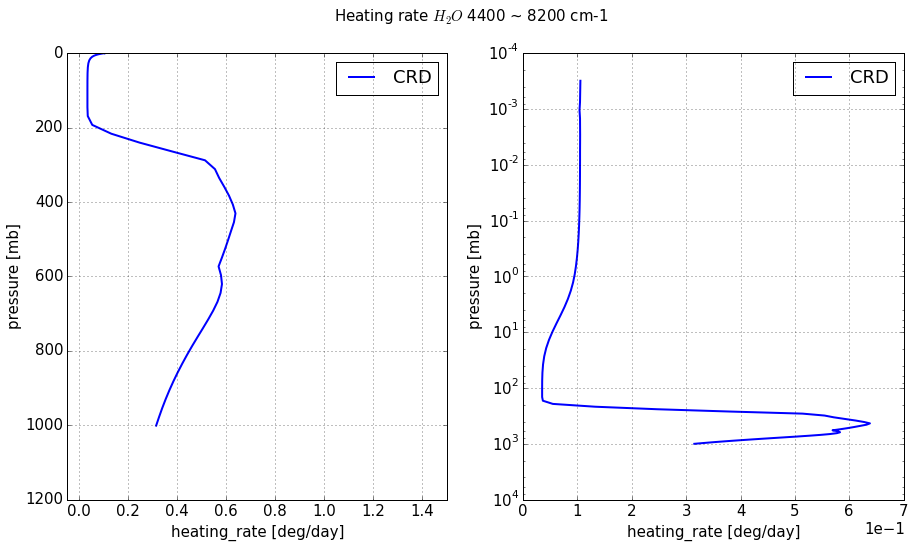

---------------------------------------------------------------------------


Wavenumber band: 8200 ~ 14280 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  220.865503  220.865503      0.005160
30   299.800000        0  220.015104  220.015104      0.119130
0   1013.000000        0  176.023173  176.023173      0.735974



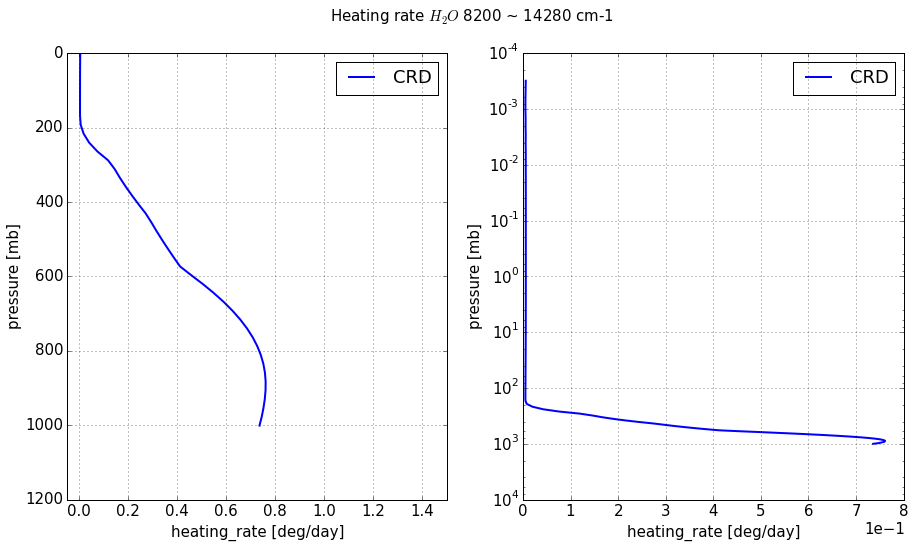

---------------------------------------------------------------------------


Wavenumber band: 14280 ~ 25000 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  265.238499  265.238499      0.000006
30   299.800000        0  265.230235  265.230235      0.001316
0   1013.000000        0  262.841654  262.841654      0.070991



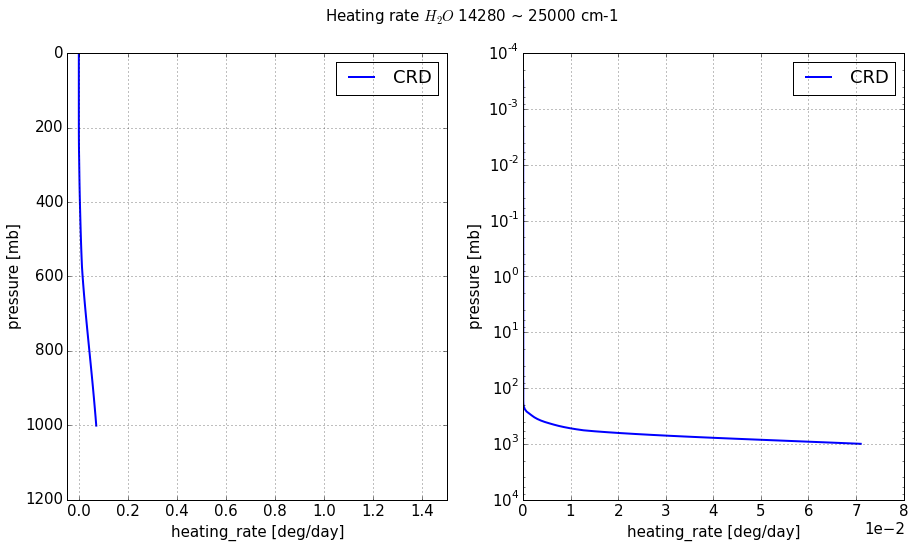

---------------------------------------------------------------------------


Wavenumber band: 1000 ~ 25000 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  629.330637  629.330637      0.461031
30   299.800000        0  620.060750  620.060750      0.989600
0   1013.000000        0  515.385483  515.385483      1.222241



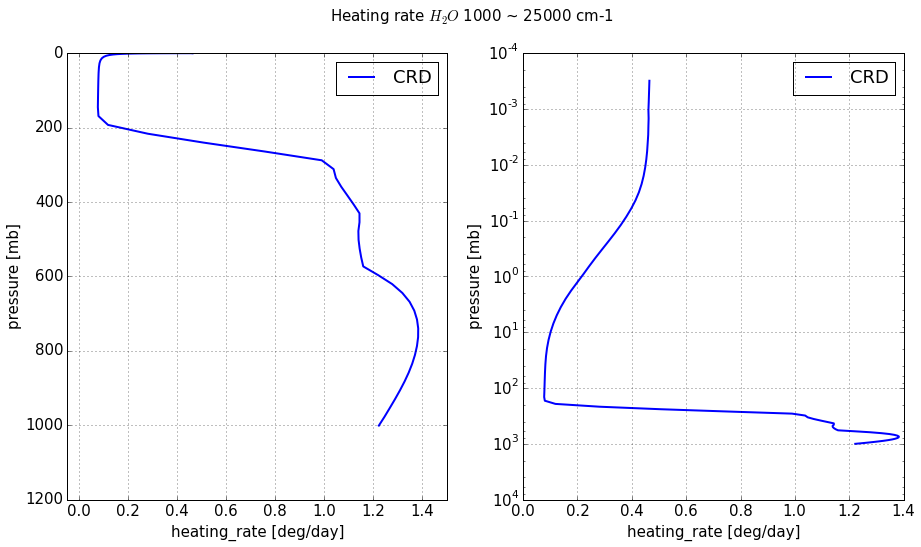

In [28]:
print('Flux tables and heating rates in various spectral bands')
print()
print()

xlim_linear = (-.05, 1.5)

fluxtableNhrplot_by_bands(define_spectral_bands(), \
                         ('CRD', 'b', '-', pnl_crd))

# In RRMTG's wavenumber bands

In [42]:

def fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, *infos_lbl):
    global name_molecule, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        
    
    
    pnls = [aeranalyse.lines2bands(pnl_lbl, wbands = pnl_rrtmg.items.values)\
            for pnl_lbl in pnls_lbl]
    
    names.append('RRTMG')
    colours.append('g')
    linestyles.append('--')
    
    aeranalyse.normalise_by_TOA_flux_down(pnl_rrtmg, 
                                          normalise_to = pnls[0])
    
    pnls.append(pnl_rrtmg)
    
    
    for item in pnl_rrtmg.items:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in pnls]
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'RRTMG Wavenumber band: {} ~ {} cm-1'.format(*item))      
        
        dfs = [pnl[item] for pnl in pnls]
        
        max_cr = max([df['heating_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Heating rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = False,
                             xlim_linear = xlim_linear,
                             xlim_log = (- .5, 20) if max_cr >= 20 else None)
    
        display.display(plt.gcf()); plt.close()

Flux tables and heating rates in RRTMG spectral bands


---------------------------------------------------------------------------


RRTMG Wavenumber band: 820.0 ~ 2600.0 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.190729  6.190729      0.075417
30   299.800000        0   5.527701  5.527701      0.059484
0   1013.000000        0   3.251457  3.251457      0.017369

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70     0.00242       -0             0        6.4447   6.190729  6.190729   
30   299.70000       -0             0        4.7174   4.531498  4.531498   
0   1013.00000       -0             0        1.8674   1.793810  1.793810   

    heating_rate  
70       0.00000  
30       0.06512  
0        0.02083  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_rate  net_flux  \
70           NaN           NaN   0.000000        0      0.075417  0.000000   
30           NaN     

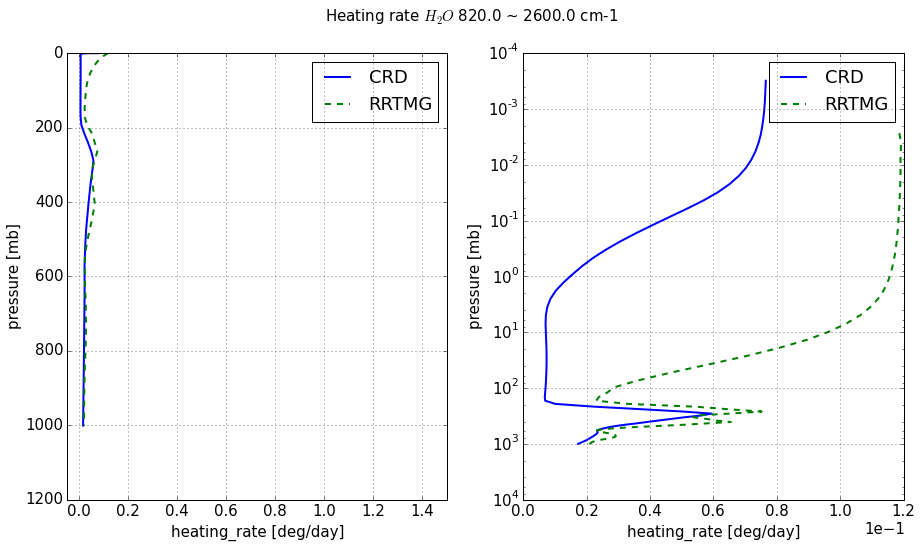

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2600.0 ~ 3250.0 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.046376  6.046376      0.001314
30   299.800000        0   5.911883  5.911883      0.016950
0   1013.000000        0   2.861515  2.861515      0.034454

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70     0.00242       -0             0        6.0548   6.046376  6.046376   
30   299.70000       -0             0        5.9225   5.914260  5.914260   
0   1013.00000       -0             0        2.8829   2.878889  2.878889   

    heating_rate  
70       0.00000  
30       0.01725  
0        0.03686  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_rate  net_flux  \
70           NaN           NaN   0.000000        0      0.001314  0.000000   
30           NaN           NaN  -0.002377        0     -0.000300 -0.002377  

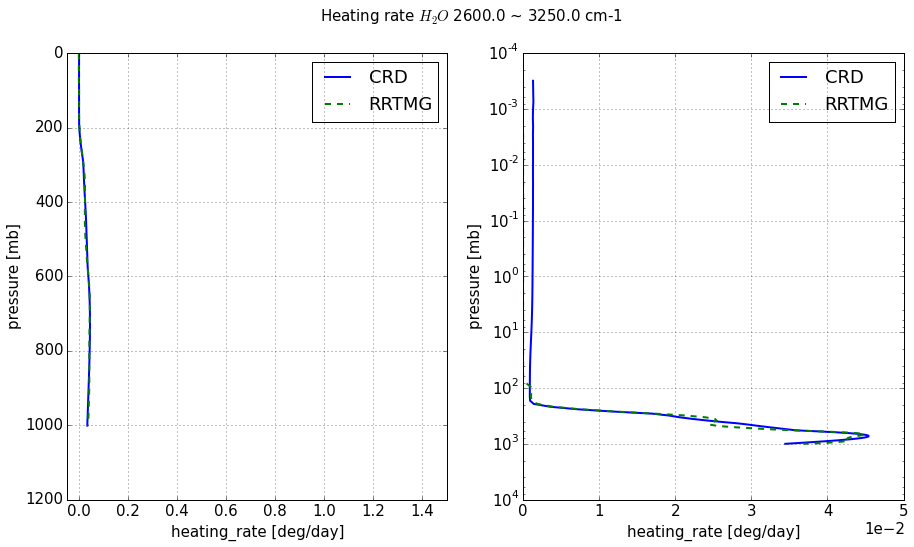

---------------------------------------------------------------------------


RRTMG Wavenumber band: 3250.0 ~ 4000.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  10.192548  10.192548      0.273868
30   299.800000        0   7.202094   7.202094      0.270346
0   1013.000000        0   0.153980   0.153980      0.011476

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       10.1825  10.192548  10.192548   
30   299.70000       -0             0        7.1431   7.150149   7.150149   
0   1013.00000       -0             0        0.0520   0.052051   0.052051   

    heating_rate  
70       0.00000  
30       0.26814  
0        0.00878  

CRD - RRTMG
    flux_difdown  flux_dirdown     flux_down  flux_up  heating_rate  \
70           NaN           NaN  1.776357e-15        0      0.273868   
30           NaN           NaN  5.194537e-02        0      0.002206   
0          

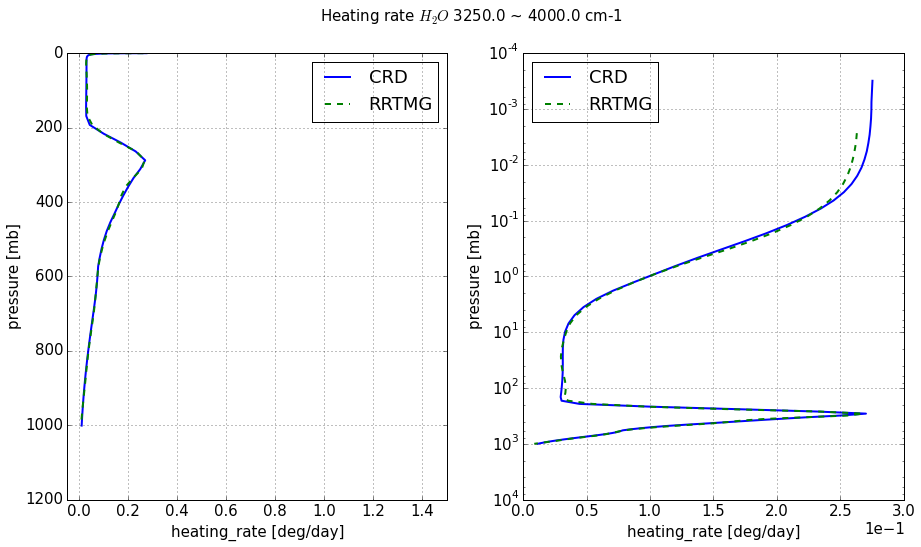

---------------------------------------------------------------------------


RRTMG Wavenumber band: 4000.0 ~ 4650.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.837002  11.837002      0.000453
30   299.800000        0  11.774872  11.774872      0.008451
0   1013.000000        0   8.867145   8.867145      0.045377

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       11.8649  11.837002  11.837002   
30   299.70000       -0             0       11.7935  11.765770  11.765770   
0   1013.00000       -0             0        8.6833   8.662883   8.662883   

    heating_rate  
70       0.00000  
30       0.00925  
0        0.04323  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_rate  net_flux  \
70           NaN           NaN   0.000000        0      0.000453  0.000000   
30           NaN           NaN   0.009102        0     -0.000799  0.

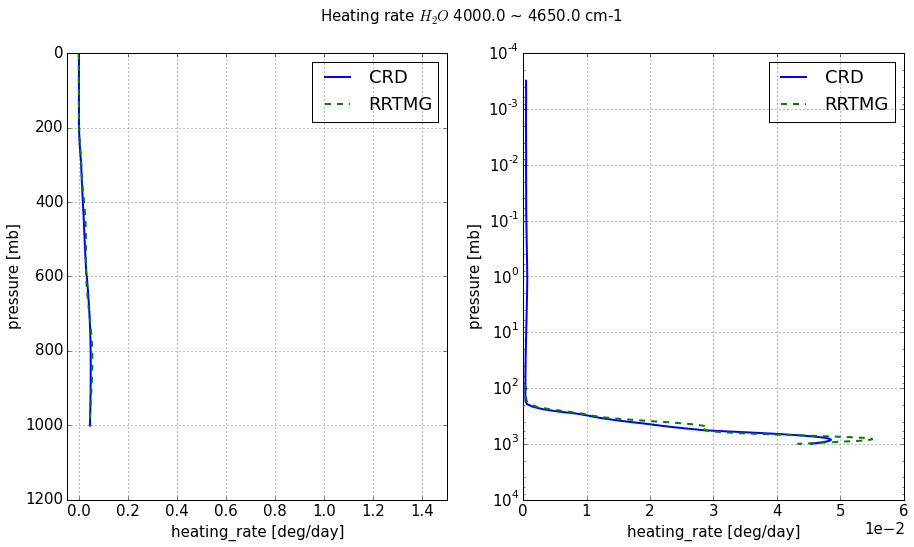

---------------------------------------------------------------------------


RRTMG Wavenumber band: 4650.0 ~ 5150.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.175502  11.175502      0.000266
30   299.800000        0  11.121692  11.121692      0.008158
0   1013.000000        0   7.732939   7.732939      0.050570

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       11.2138  11.175502  11.175502   
30   299.70000       -0             0       11.1614  11.123281  11.123281   
0   1013.00000       -0             0        7.8399   7.813124   7.813124   

    heating_rate  
70       0.00000  
30       0.00813  
0        0.04522  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_rate  net_flux  \
70           NaN           NaN   0.000000        0      0.000266  0.000000   
30           NaN           NaN  -0.001588        0      0.000028 -0.

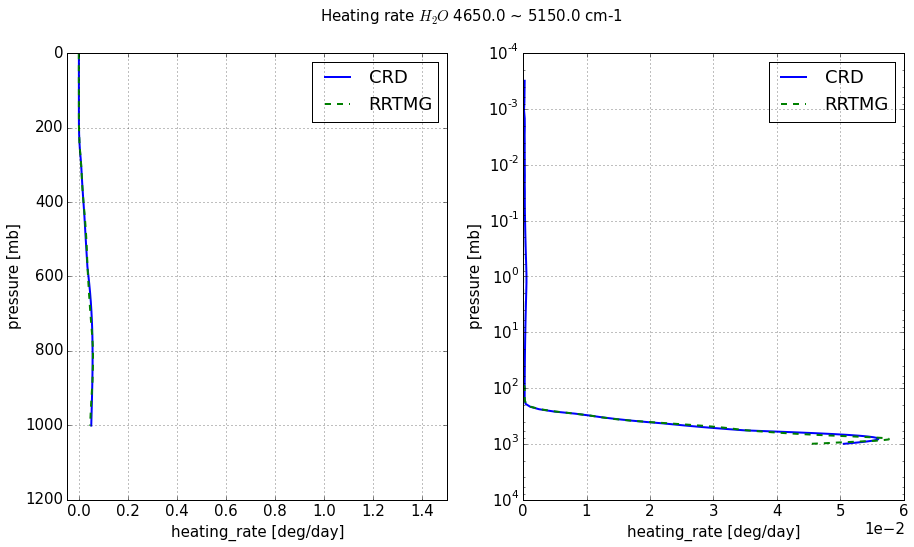

---------------------------------------------------------------------------


RRTMG Wavenumber band: 5150.0 ~ 6150.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  28.035864  28.035864      0.051710
30   299.800000        0  26.271317  26.271317      0.190879
0   1013.000000        0  14.381275  14.381275      0.060881

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       27.8133  28.035864  28.035864   
30   299.70000       -0             0       25.9028  26.110076  26.110076   
0   1013.00000       -0             0       13.8181  13.928673  13.928673   

    heating_rate  
70       0.00000  
30       0.19698  
0        0.07250  

CRD - RRTMG
    flux_difdown  flux_dirdown     flux_down  flux_up  heating_rate  \
70           NaN           NaN -3.552714e-15        0      0.051710   
30           NaN           NaN  1.612413e-01        0     -0.006101   
0          

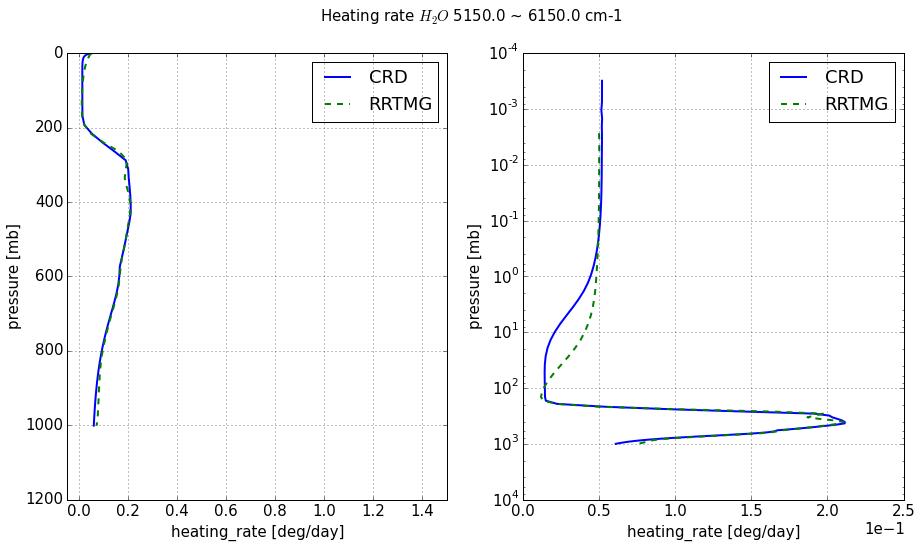

---------------------------------------------------------------------------


RRTMG Wavenumber band: 6150.0 ~ 7700.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  51.855615  51.855615      0.052831
30   299.800000        0  49.114584  49.114584      0.314601
0   1013.000000        0  22.024083  22.024083      0.176725

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       51.4658  51.855615  51.855615   
30   299.70000       -0             0       48.5907  48.958738  48.958738   
0   1013.00000       -0             0       21.8532  22.018722  22.018722   

    heating_rate  
70       0.00000  
30       0.32089  
0        0.17859  

CRD - RRTMG
    flux_difdown  flux_dirdown     flux_down  flux_up  heating_rate  \
70           NaN           NaN -7.105427e-15        0      0.052831   
30           NaN           NaN  1.558463e-01        0     -0.006289   
0          

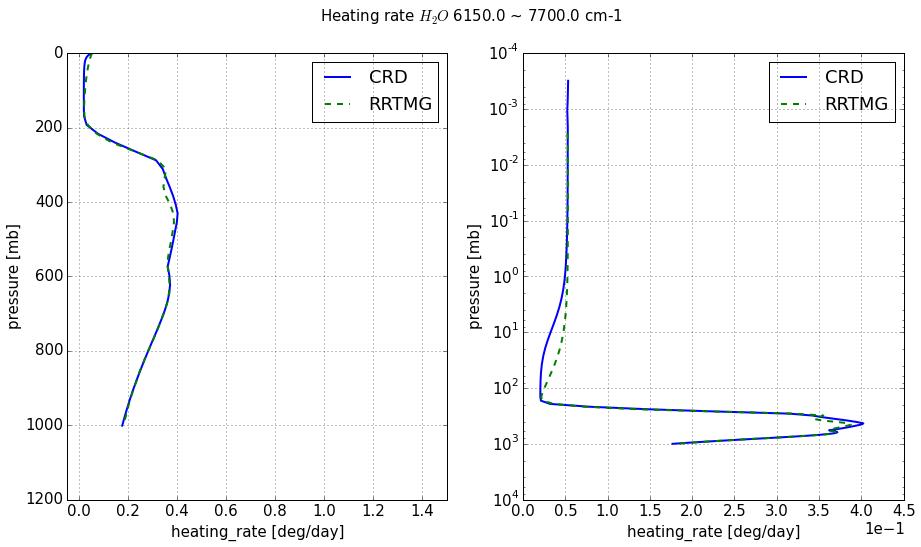

---------------------------------------------------------------------------


RRTMG Wavenumber band: 7700.0 ~ 8050.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  12.480126  12.480126      0.000006
30   299.800000        0  12.479372  12.479372      0.000127
0   1013.000000        0  12.131531  12.131531      0.010220

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       12.1468  12.480126  12.480126   
30   299.70000       -0             0       12.1462  12.479509  12.479509   
0   1013.00000       -0             0       11.7689  12.091855  12.091855   

    heating_rate  
70       0.00000  
30       0.00011  
0        0.01195  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_rate  net_flux  \
70           NaN           NaN   0.000000        0      0.000006  0.000000   
30           NaN           NaN  -0.000138        0      0.000017 -0.

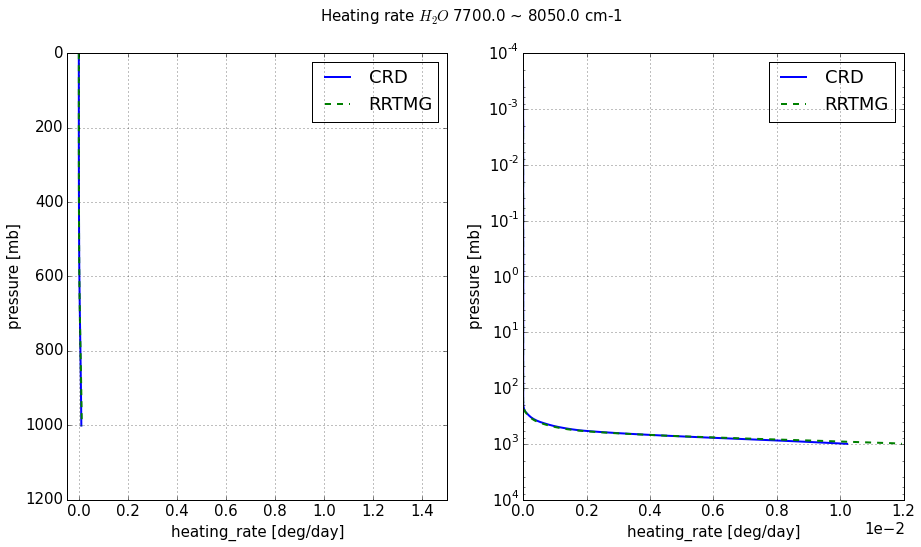

---------------------------------------------------------------------------


RRTMG Wavenumber band: 8050.0 ~ 12850.0 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  175.812128  175.812128      0.005121
30   299.800000        0  174.987290  174.987290      0.115096
0   1013.000000        0  134.939325  134.939325      0.644180

RRTMG
      pressure   flux_up  flux_difdown  flux_dirdown   flux_down    net_flux  \
70     0.00242 -0.000102             0      172.8713  175.812128  175.812026   
30   299.70000 -0.000000             0      171.9919  174.917768  174.917768   
0   1013.00000 -0.000000             0      132.7270  134.984907  134.984907   

    heating_rate  
70       0.00000  
30       0.12220  
0        0.62027  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down   flux_up  heating_rate  net_flux  \
70           NaN           NaN   0.000000  0.000102      0.005121  0.000102   
30           NaN           NaN   0.069522  0.

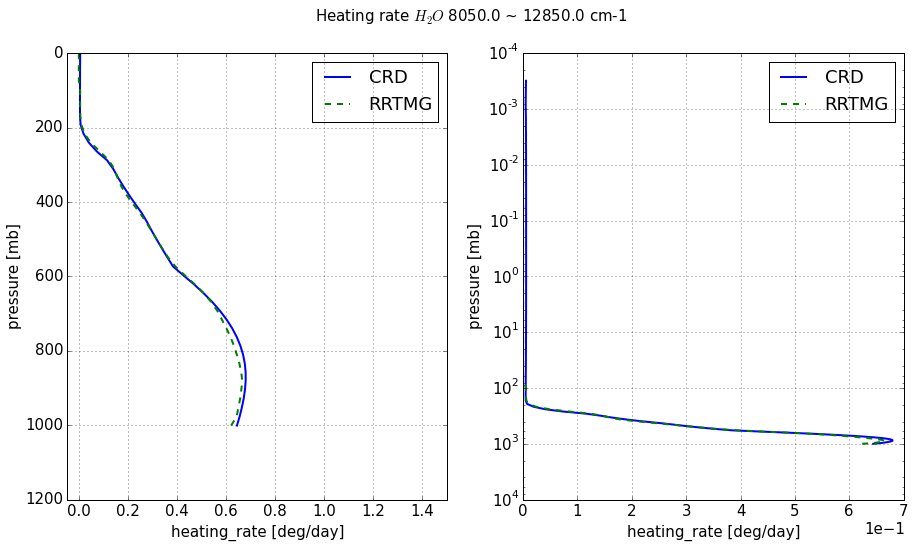

---------------------------------------------------------------------------


RRTMG Wavenumber band: 12850.0 ~ 16000.0 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  108.653750  108.653750      0.000045
30   299.800000        0  108.622362  108.622362      0.004964
0   1013.000000        0  103.098029  103.098029      0.136599

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown   flux_down    net_flux  \
70     0.00242       -0             0      109.0936  108.653750  108.653750   
30   299.70000       -0             0      109.0649  108.625166  108.625166   
0   1013.00000       -0             0      103.3554  102.938686  102.938686   

    heating_rate  
70       0.00000  
30       0.00455  
0        0.14624  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_rate  net_flux  \
70           NaN           NaN   0.000000        0      0.000045  0.000000   
30           NaN           NaN  -0.002804        0

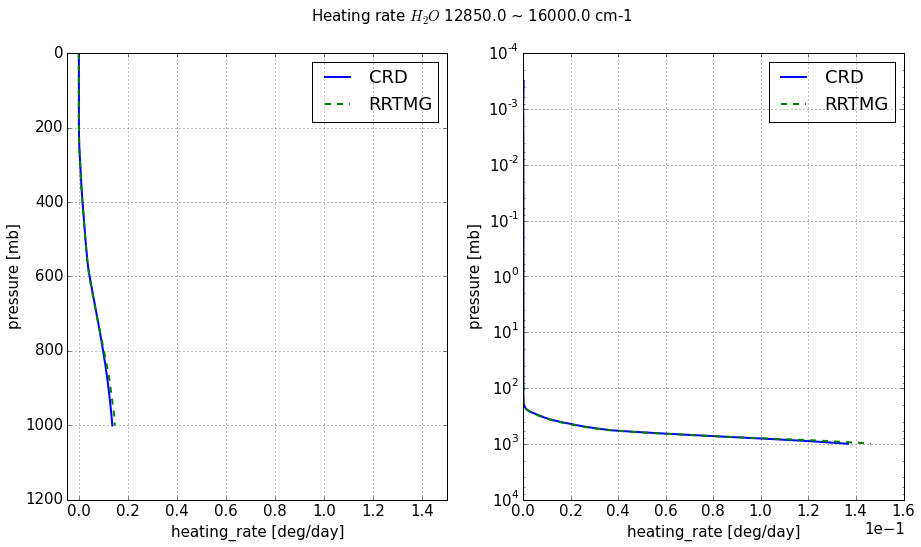

---------------------------------------------------------------------------


RRTMG Wavenumber band: 16000.0 ~ 22650.0 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  171.966627  171.966627      0.000000
30   299.800000        0  171.963216  171.963216      0.000544
0   1013.000000        0  170.861643  170.861643      0.034328

RRTMG
      pressure   flux_up  flux_difdown  flux_dirdown   flux_down    net_flux  \
70     0.00242 -0.000099             0      173.5962  171.966627  171.966528   
30   299.70000 -0.000099             0      173.5930  171.963457  171.963358   
0   1013.00000 -0.000000             0      172.4621  170.843173  170.843173   

    heating_rate  
70       0.00000  
30       0.00050  
0        0.03616  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down   flux_up  heating_rate  net_flux  \
70           NaN           NaN   0.000000  0.000099      0.000000  0.000099   
30           NaN           NaN  -0.000241  0

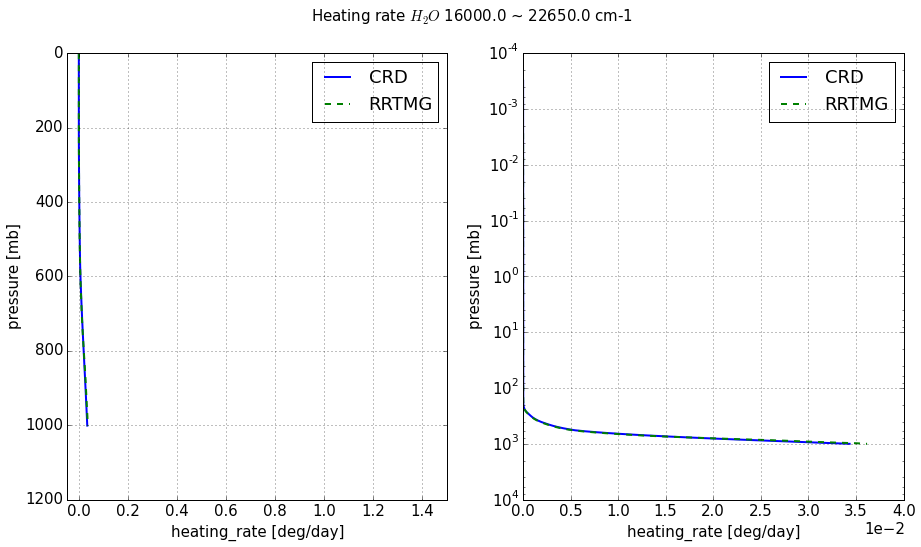

---------------------------------------------------------------------------


RRTMG Wavenumber band: 22650.0 ~ 29000.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  63.770666  63.770666      0.000000
30   299.800000        0  63.770657  63.770657      0.000001
0   1013.000000        0  63.767506  63.767506      0.000106

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       64.7475  63.770666  63.770666   
30   299.70000       -0             0       64.7475  63.770666  63.770666   
0   1013.00000       -0             0       64.7475  63.770666  63.770666   

    heating_rate  
70             0  
30             0  
0              0  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_rate  net_flux  \
70           NaN           NaN   0.000000        0      0.000000  0.000000   
30           NaN           NaN  -0.000009        0      0.000001 -

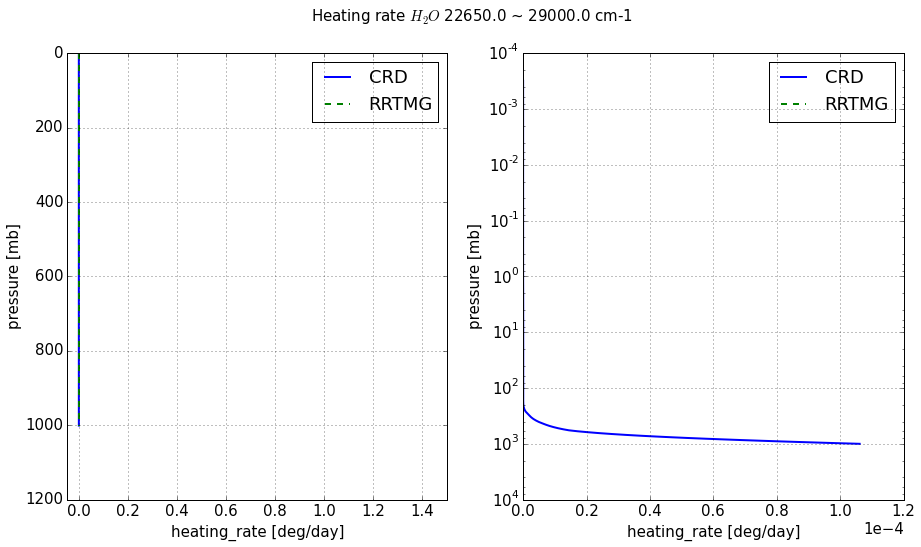

---------------------------------------------------------------------------


RRTMG Wavenumber band: 29000.0 ~ 38000.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  23.027941  23.027941             0
30   299.800000        0  23.027941  23.027941             0
0   1013.000000        0  23.027941  23.027941             0

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       25.0761  23.027941  23.027941   
30   299.70000       -0             0       25.0761  23.027941  23.027941   
0   1013.00000       -0             0       25.0761  23.027941  23.027941   

    heating_rate  
70             0  
30             0  
0              0  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_rate  net_flux  \
70           NaN           NaN          0        0             0         0   
30           NaN           NaN          0        0             0  

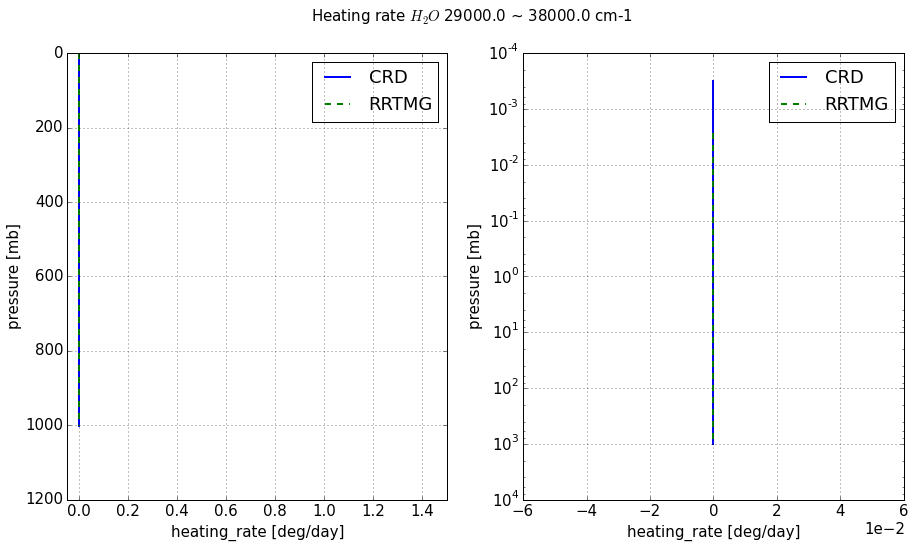

---------------------------------------------------------------------------


RRTMG Wavenumber band: 38000.0 ~ 50000.0 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   1.544534  1.544534             0
30   299.800000        0   1.544534  1.544534             0
0   1013.000000        0   1.544534  1.544534             0

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70     0.00242       -0             0          1.54   1.544534  1.544534   
30   299.70000       -0             0          1.54   1.544534  1.544534   
0   1013.00000       -0             0          1.54   1.544534  1.544534   

    heating_rate  
70             0  
30             0  
0              0  

CRD - RRTMG
    flux_difdown  flux_dirdown  flux_down  flux_up  heating_rate  net_flux  \
70           NaN           NaN          0        0             0         0   
30           NaN           NaN          0        0             0         0

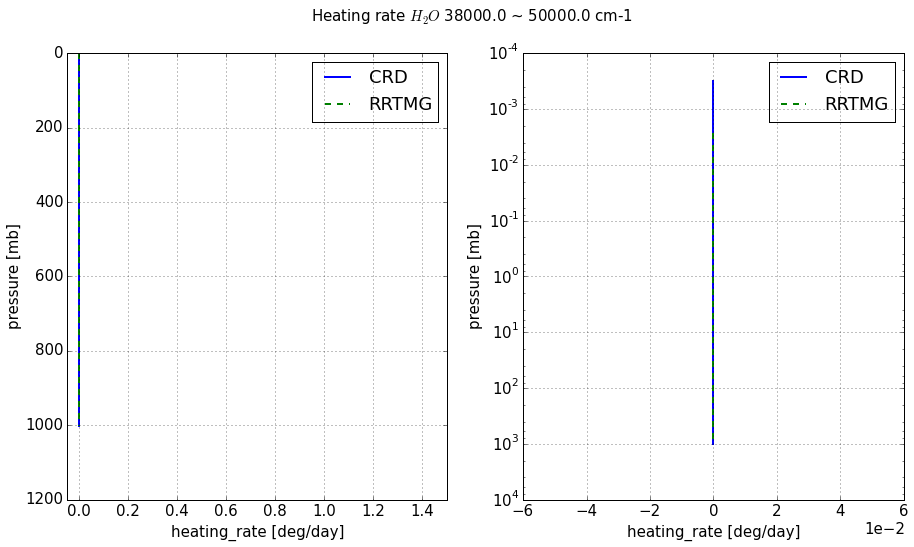

In [43]:
print('Flux tables and heating rates in RRTMG spectral bands')
print()
print()

fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, \
                                ('CRD', 'b', '-', pnl_crd)) 

# In CLIRAD's wavenumber bands

In [40]:

def fluxtableNhrplot_by_clirad_bands(pnl_clirad, *infos_lbl):    
    global name_molecule, xlim_linear
    clirad_wbands = rtmtools.clirad.sw.info.wavenumber_bands()
    wbands = list(range(1, len(clirad_wbands) + 1))
    wranges = {wband: clirad_wbands[wband] for wband in wbands}
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
          
    pnls = [rtmtools.clirad.sw.analyse.lines2bands(pnl_lbl, wbands = wranges)\
            for pnl_lbl in pnls_lbl]
    
    names.append('CLIRAD')
    colours.append('b')
    linestyles.append('--')
    
    aeranalyse.normalise_by_TOA_flux_down(pnl_clirad, 
                                          normalise_to = pnls[0])
    pnls.append(pnl_clirad)
    
    for wband in wbands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[wband].loc[atm_levels, :] for pnl in pnls]
        
        wlabel = ' '.join(['{} ~ {}'.format(*interval) for interval in wranges[wband]]) + ' cm-1'
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {}, {}'.format(wband, wlabel))
        
        dfs = [pnl[wband] for pnl in pnls]
        
        max_cr = max([df['heating_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Heating rate {} {}'.format(name_molecule, wlabel),
                              cooling_rate = False,\
                             xlim_linear = xlim_linear,
                             xlim_log = (- .5, 20) if max_cr >= 20 else None)
    
        display.display(plt.gcf()); plt.close()    


Flux tables and heating rates in CLIRAD spectral bands


---------------------------------------------------------------------------


Wavenumber band: 1, 35088 ~ 44444 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   3.514604  3.514604             0
30   299.800000        0   3.514604  3.514604             0
0   1013.000000        0   3.514604  3.514604             0

CLIRAD
       pressure       flux_up  flux_down  net_flux  heating_rate
70     0.002417 -4.817478e-12   3.514535  3.514535      0.170928
30   299.800000 -2.064616e-12   2.147950  2.147950     -0.019623
0   1013.000000 -0.000000e+00   2.701357  2.701357     -0.001352

CRD - CLIRAD
    pressure       flux_up  flux_down  net_flux  heating_rate
70         0  4.817478e-12   0.000069  0.000069     -0.170928
30         0  2.064616e-12   1.366653  1.366653      0.019623
0          0  0.000000e+00   0.813247  0.813247      0.001352



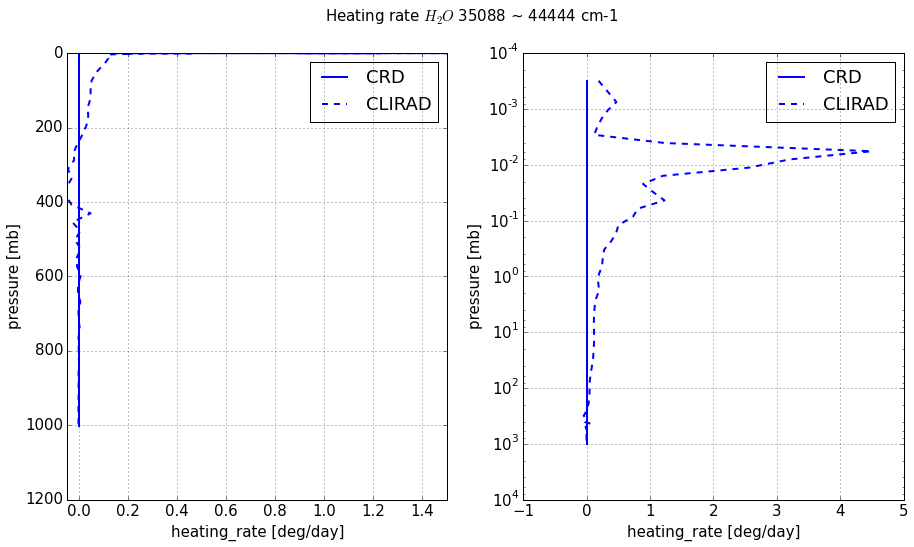

---------------------------------------------------------------------------


Wavenumber band: 2, 33333 ~ 35088 44444 ~ 57142 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   3.852331  3.852331             0
30   299.800000        0   3.852331  3.852331             0
0   1013.000000        0   3.852331  3.852331             0

CLIRAD
       pressure       flux_up  flux_down  net_flux  heating_rate
70     0.002417 -7.469773e-13   3.852320  3.852320  2.327879e-02
30   299.800000 -3.201433e-13   3.852234  3.852234  6.795004e-07
0   1013.000000 -0.000000e+00   3.852171  3.852171  6.794891e-07

CRD - CLIRAD
    pressure       flux_up  flux_down  net_flux  heating_rate
70         0  7.469773e-13   0.000011  0.000011 -2.327879e-02
30         0  3.201433e-13   0.000097  0.000097 -6.795004e-07
0          0  0.000000e+00   0.000161  0.000161 -6.794891e-07



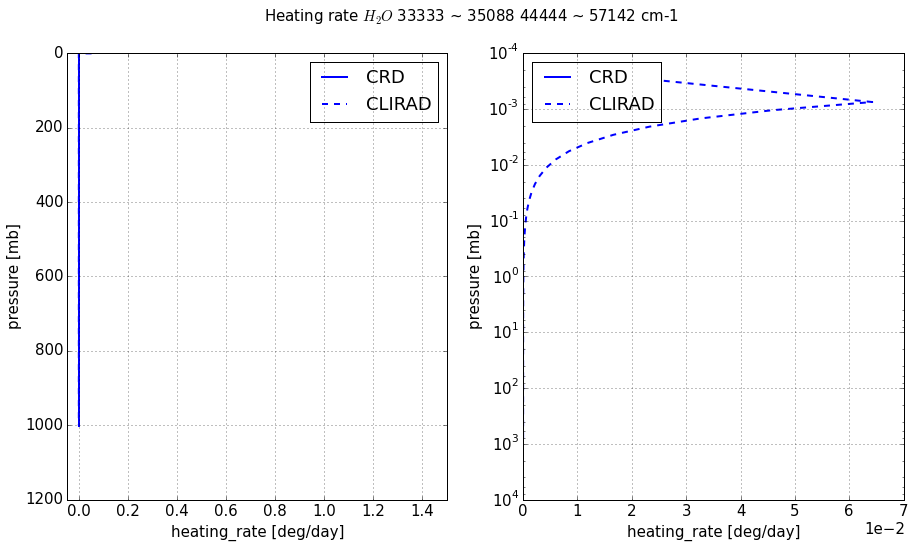

---------------------------------------------------------------------------


Wavenumber band: 3, 30770 ~ 33333 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   7.939345  7.939345             0
30   299.800000        0   7.939345  7.939345             0
0   1013.000000        0   7.939345  7.939345             0

CLIRAD
       pressure       flux_up  flux_down  net_flux  heating_rate
70     0.002417 -1.662502e-13   7.939343  7.939343  5.518143e-03
30   299.800000 -7.127224e-14   7.939323  7.939323  1.610760e-07
0   1013.000000 -0.000000e+00   7.939309  7.939309  1.610757e-07

CRD - CLIRAD
    pressure       flux_up  flux_down  net_flux  heating_rate
70         0  1.662502e-13   0.000002  0.000002 -5.518143e-03
30         0  7.127224e-14   0.000022  0.000022 -1.610760e-07
0          0  0.000000e+00   0.000036  0.000036 -1.610757e-07



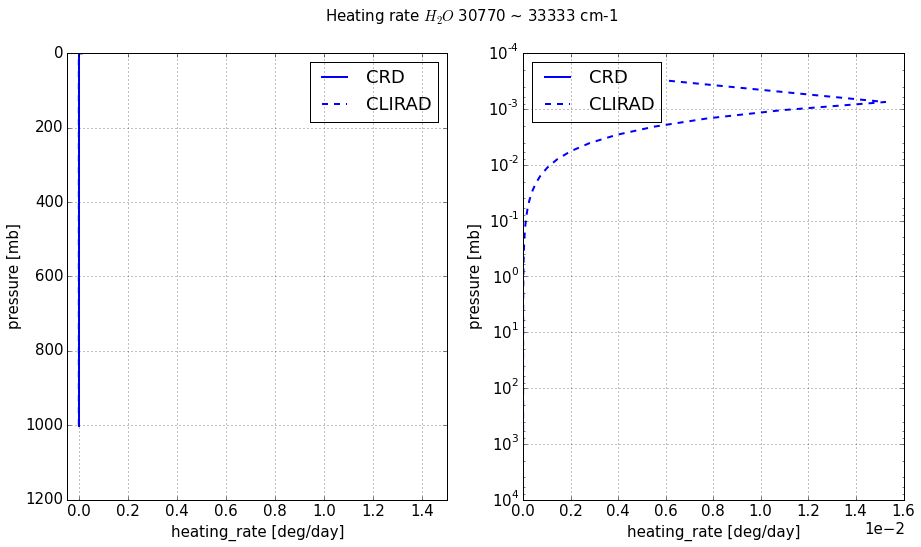

---------------------------------------------------------------------------


Wavenumber band: 4, 25000 ~ 30770 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  37.994457  37.994457  0.000000e+00
30   299.800000        0  37.994453  37.994453  6.398401e-07
0   1013.000000        0  37.993106  37.993106  4.493202e-05

CLIRAD
       pressure       flux_up  flux_down   net_flux  heating_rate
70     0.002417 -2.755214e-13  37.994457  37.994457  1.006937e-02
30   299.800000 -1.181866e-13  37.994428  37.994428  2.939280e-07
0   1013.000000 -0.000000e+00  37.994400  37.994400  2.939279e-07

CRD - CLIRAD
    pressure       flux_up  flux_down      net_flux  heating_rate
70         0  2.755214e-13   0.000000  2.771117e-13 -1.006937e-02
30         0  1.181866e-13   0.000024  2.446516e-05  3.459121e-07
0          0  0.000000e+00  -0.001294 -1.293903e-03  4.463809e-05



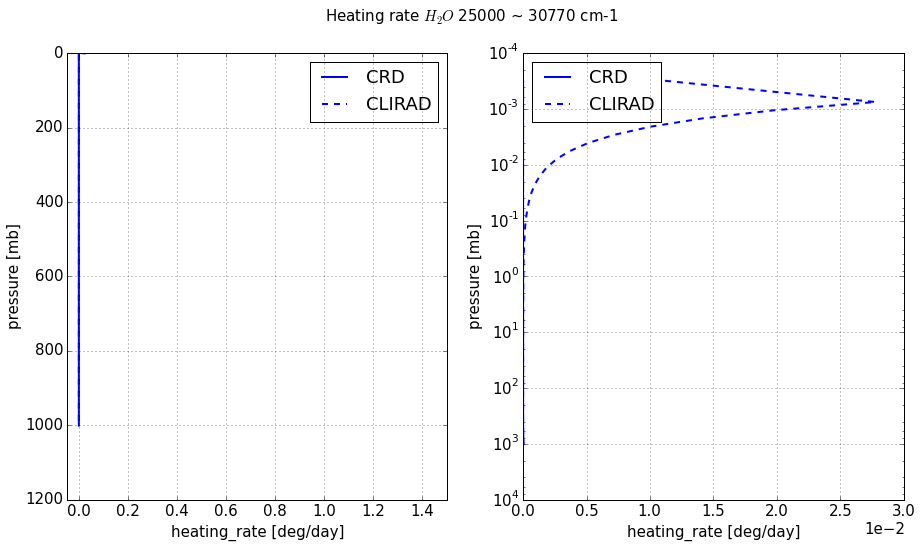

---------------------------------------------------------------------------


Wavenumber band: 5, 14286 ~ 25000 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  265.032084  265.032084      0.000006
30   299.800000        0  265.023952  265.023952      0.001294
0   1013.000000        0  262.667086  262.667086      0.070189

CLIRAD
       pressure       flux_up   flux_down    net_flux  heating_rate
70     0.002417 -1.313133e-08  265.032084  265.032084      0.068761
30   299.800000 -1.311769e-08  265.029308  265.029308      0.000462
0   1013.000000 -0.000000e+00  262.394720  262.394720      0.105804

CRD - CLIRAD
    pressure       flux_up  flux_down      net_flux  heating_rate
70         0  1.313133e-08   0.000000  1.313134e-08     -0.068756
30         0  1.311769e-08  -0.005357 -5.356843e-03      0.000832
0          0  0.000000e+00   0.272366  2.723662e-01     -0.035616



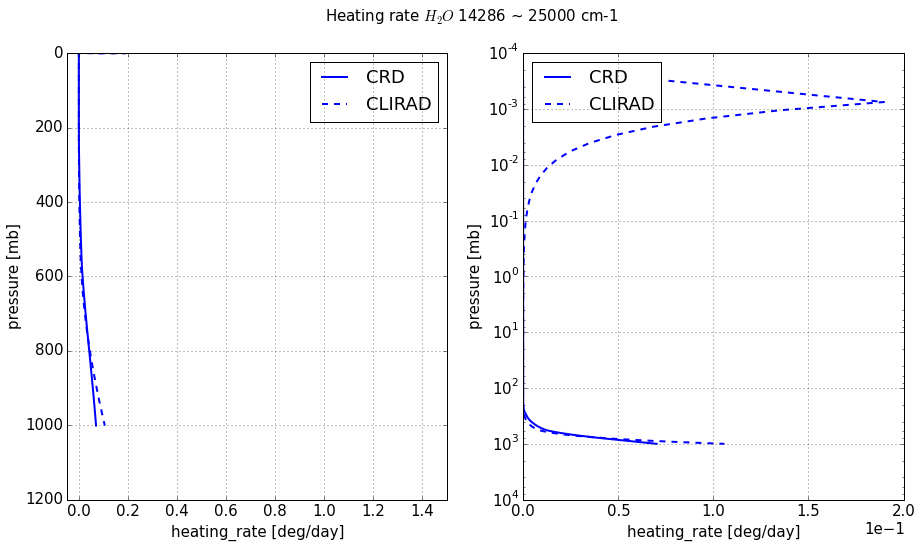

---------------------------------------------------------------------------


Wavenumber band: 6, 8200 ~ 14280 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  220.865503  220.865503      0.005160
30   299.800000        0  220.015104  220.015104      0.119130
0   1013.000000        0  176.023173  176.023173      0.735974

CLIRAD
       pressure   flux_up   flux_down    net_flux  heating_rate
70     0.002417 -0.000147  220.865303  220.865156      0.482215
30   299.800000 -0.000059  220.058050  220.057991      0.124549
0   1013.000000 -0.000000  175.214572  175.214572      0.705824

CRD - CLIRAD
    pressure   flux_up  flux_down  net_flux  heating_rate
70         0  0.000147   0.000200  0.000347     -0.477055
30         0  0.000059  -0.042946 -0.042887     -0.005419
0          0  0.000000   0.808601  0.808601      0.030150



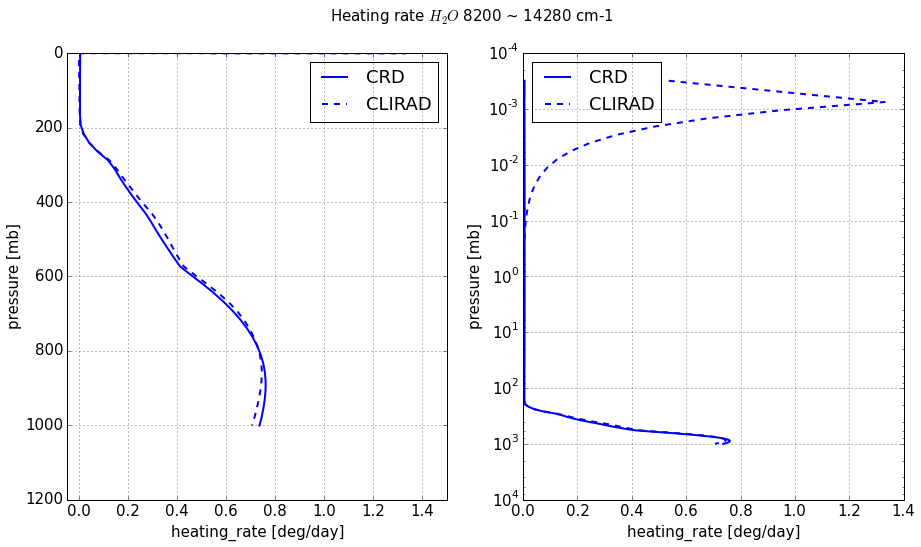

---------------------------------------------------------------------------


Wavenumber band: 7, 4400 ~ 8200 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  113.874482  113.874482      0.104813
30   299.800000        0  109.312006  109.312006      0.514142
0   1013.000000        0   65.972910   65.972910      0.315031

CLIRAD
       pressure   flux_up   flux_down    net_flux  heating_rate
70     0.002417 -0.000070  113.874411  113.874341      0.275648
30   299.800000 -0.000025  109.372959  109.372934      0.526873
0   1013.000000 -0.000000   68.443046   68.443046      0.293032

CRD - CLIRAD
    pressure   flux_up  flux_down  net_flux  heating_rate
70         0  0.000070   0.000071  0.000141     -0.170835
30         0  0.000025  -0.060953 -0.060928     -0.012731
0          0  0.000000  -2.470137 -2.470137      0.022000



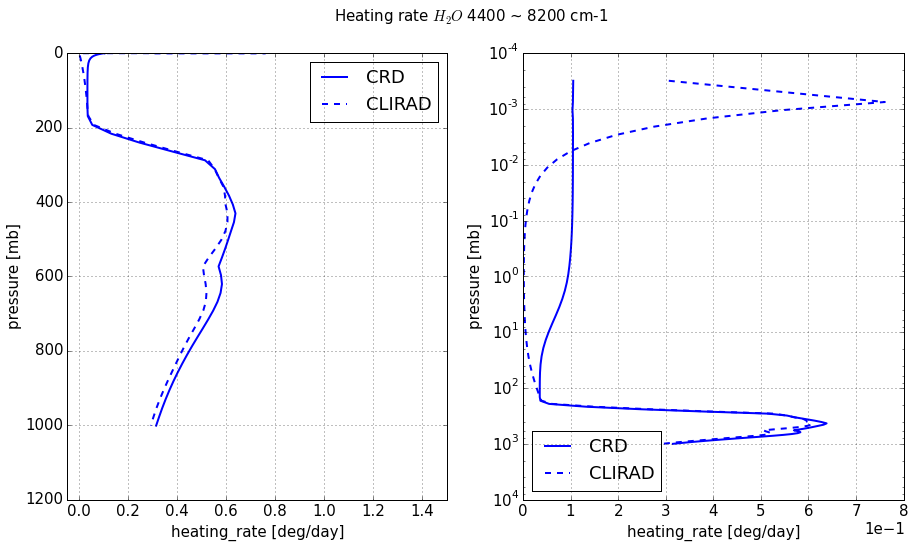

---------------------------------------------------------------------------


Wavenumber band: 8, 1000 ~ 4400 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  29.352153  29.352153      0.351053
30   299.800000        0  25.503405  25.503405      0.355012
0   1013.000000        0  10.547747  10.547747      0.100244

CLIRAD
       pressure   flux_up  flux_down   net_flux  heating_rate
70     0.002417 -0.000016  29.352215  29.352198      0.099339
30   299.800000 -0.000005  25.551349  25.551344      0.358429
0   1013.000000 -0.000000  11.293427  11.293427      0.097072

CRD - CLIRAD
    pressure   flux_up  flux_down  net_flux  heating_rate
70         0  0.000016  -0.000061 -0.000045      0.251714
30         0  0.000005  -0.047945 -0.047940     -0.003417
0          0  0.000000  -0.745680 -0.745680      0.003172



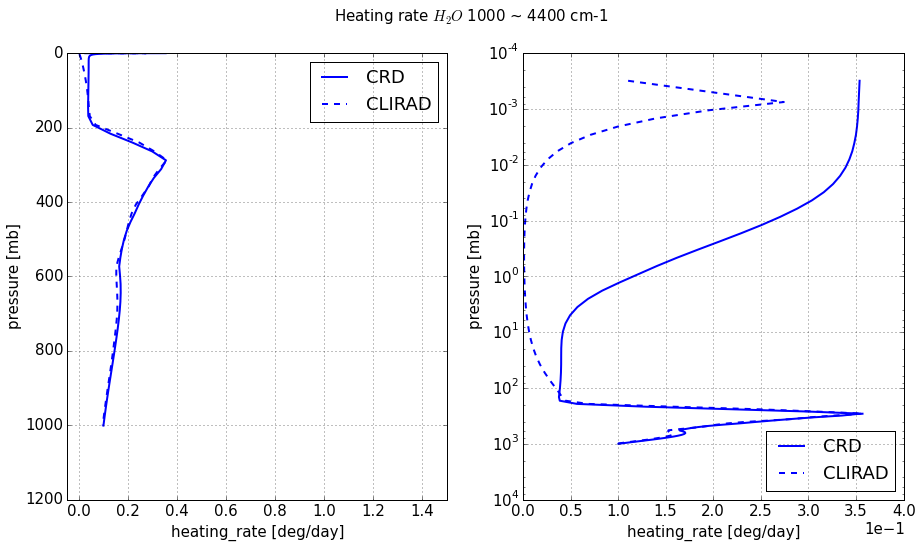

In [41]:
print('Flux tables and heating rates in CLIRAD spectral bands')
print()
print()

fluxtableNhrplot_by_clirad_bands(pnl_clirad, \
                                ('CRD', 'b', '-', pnl_crd))